# Propagating uncertainty through a simulation

This example was inspired by [a DifferentialEquations.jl tutorial](https://github.com/JuliaDiffEq/DiffEqTutorials.jl/blob/625e54235621958a0396748382c62674c75acbc9/PhysicalModels/NumberUncertainties.ipynb).

In [1]:
# Tell Julia to use the packages specified in the Project.toml
# and Manifest.toml files contained in the DynamicWalking2018.jl
# repository. This ensures that you will have the same packages
# that were used to create this tutorial. 
using Pkg
pkg"activate .."
pkg"instantiate"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `git@github.com:JuliaRegistries/General.git`


In [2]:
using RigidBodySim
using RigidBodyDynamics

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/41f396c72270c88d4098c6aff59a013a05364eb9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/41f396c72270c88d4098c6aff59a013a05364eb9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Info: Recompiling stale cache file /home/rdeits/.julia/compiled/v1.0/RigidBodySim/s3FmJ.ji for RigidBodySim [e61f16d8-a6b7-5689-8d03-627c2b27ebce]
└ @ Base loading.jl:1190


## Measurements.jl

In this notebook, we'll use the Julia package [Measurements.jl](https://github.com/JuliaPhysics/Measurements.jl) to get a feel for how uncertainty in the initial conditions of a simulation is propagated through the dynamics of a RigidBodyDynamics `Mechanism`.

Measurements.jl is a package that allows you to define numbers with uncertainties, perform calculations involving them, and easily get the uncertainty of the result according to linear error propagation theory. It defines the `Measurement` type, which represents both the nominal value of a measurement, as well as its uncertainty (in the form of a standard deviation).

In [3]:
using Measurements

┌ Info: Recompiling stale cache file /home/rdeits/.julia/compiled/v1.0/Measurements/8B0my.ji for Measurements [eff96d63-e80a-5855-80a2-b1b0885c5ab7]
└ @ Base loading.jl:1190


`Measurement`s can be created using

In [4]:
meas = measurement(1.0, 0.1)  # value 1.0, stddev 0.1

1.0 ± 0.1

In [5]:
typeof(meas)

Measurement{Float64}

Equivalently, we can use the fancy $\pm$ syntax (type `\pm <tab>`):

In [6]:
1.0 ± 0.1

1.0 ± 0.1

Measurements.jl works through operator overloading, so you can do stuff like:

In [7]:
(1.0 ± 0.1) + (2.0 ± 0.2)

3.0 ± 0.223606797749979

There are a few subtleties to using Measurements.jl. Please see [their documentation](http://measurementsjl.readthedocs.io/en/stable/), as well as [the DifferentialEquations.jl tutorial](https://github.com/JuliaDiffEq/DiffEqTutorials.jl/blob/625e54235621958a0396748382c62674c75acbc9/PhysicalModels/NumberUncertainties.ipynb) for some valuable additional information on the interplay between Measurements.jl and DifferentialEquations.jl.

**Note:** Measurements.jl does *not* do interval arithmetic. If formal guarantees on the range of outputs are required, please use [IntervalArithmetic.jl](https://github.com/JuliaIntervals/IntervalArithmetic.jl) instead. In addition, the linear propagation assumption will result in errors, especially if uncertainty is propagated through highly nonlinear functions.

## Passive dynamics of the double pendulum

Let's use Measurements.jl with RigidBodySim.

We'll load the double pendulum from a URDF again:

In [8]:
urdf = "data/doublependulum.urdf"
mechanism = parse_urdf(Float64, urdf)
remove_fixed_tree_joints!(mechanism)
shoulder, elbow = joints(mechanism);

Next, we'll create a `MechanismState` for the mechanism, but with a `Measurement{Float64}` element type:

In [9]:
const state = MechanismState{Measurement{Float64}}(mechanism)

MechanismState{Measurement{Float64}, Float64, Measurement{Float64}, …}(…)

Suppose we know that the initial joint velocities are precisely zero, but the joint angles have a standard deviation of `0.05` radians (independently distributed). We can encode this as follows:

In [10]:
zero_velocity!(state)
set_configuration!(state, shoulder, 0.4 ± 0.05)
set_configuration!(state, elbow, 0.5 ± 0.05);

Let's investigate how this uncertainty propagates through the passive dynamics of the double pendulum. We'll proceed by setting up an `ODEProblem` as usual:

In [11]:
passive_dynamics = Dynamics(mechanism)
tspan = (0., 3.5)
problem = ODEProblem(passive_dynamics, state, tspan)

ODEProblem with uType Array{Measurement{Float64},1} and tType Float64. In-place: true
timespan: (0.0, 3.5)
u0: Measurement{Float64}[0.4±0.05, 0.5±0.05, 0.0±0.0, 0.0±0.0]

And solve the problem:

In [12]:
dt = 1e-3
sol = solve(problem, RK4(), dtmin = dt, dtmax = dt, force_dtmin=true)
last(sol)

4-element Array{Measurement{Float64},1}:
  0.0175202355308281 ± 0.041977849243667376
  0.2051450556880398 ± 0.11841980467543833 
  0.4277440470992677 ± 0.05935355133170462 
 -3.3649951067535233 ± 0.13464932043566638 

**Note:** we're using a fixed-timestep solver, because using a variable-timestep solver would result in nonzero uncertainty propagating into the integrator time steps, making the results hard to interpret. This is not without its consequences, as the accuracy may be quite bad, especially for the example with large initial joint velocities below.

In [13]:
@assert all(x -> iszero(Measurements.uncertainty(x)), sol.t)

Let's say we're interested in the joint velocity of the elbow joint. We can extract the nominal value and a one-$\sigma$ band around it, and plot the results using [Plots.jl](https://github.com/JuliaPlots/Plots.jl) (with the [GR](https://github.com/jheinen/GR.jl) backend):

In [14]:
using Plots
gr()

Plots.GRBackend()

In [15]:
function plot_elbow_velocity(sol)
    # extract (nominal value of) time
    t = Measurements.value.(sol.t)
    
    # extract elbow joint velocity
    v_elbow = map(sol.u) do statevector
        copyto!(state, statevector)
        velocity(state, elbow)[1]
    end
    
    # nominal, ± σ:
    nominal = Measurements.value.(v_elbow)
    nom_plus_std = nominal .- Measurements.uncertainty.(v_elbow)
    nom_minus_std = nominal .+ Measurements.uncertainty.(v_elbow)
    
    # plot
    p = plot(xlabel = "Time [s]", ylabel = "Elbow velocity [rad/s]")
    plot!(t, nom_minus_std, fillrange = nom_plus_std, fillalpha = 0.5, linealpha = 0.0, legend = false)
    plot!(t, nominal)
end

plot_elbow_velocity (generic function with 1 method)

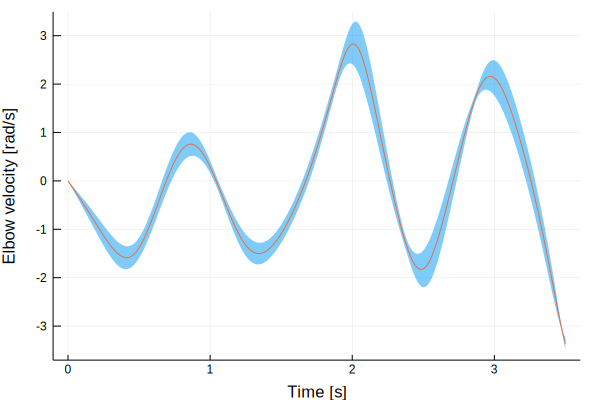

In [16]:
plot_elbow_velocity(sol)

## A different initial condition

Let's look at an initial condition with some fairly large initial velocities:

In [17]:
set_velocity!(state, shoulder, 2.0)
set_velocity!(state, elbow, 3.5)
set_configuration!(state, shoulder, 0.4 ± 0.05)
set_configuration!(state, elbow, 0.5 ± 0.05);

Set up and solve another `ODEProblem`:

In [18]:
problem = ODEProblem(passive_dynamics, state, tspan)
sol = solve(problem, RK4(), dtmin = dt, dtmax = dt, force_dtmin=true);

And plot the results:

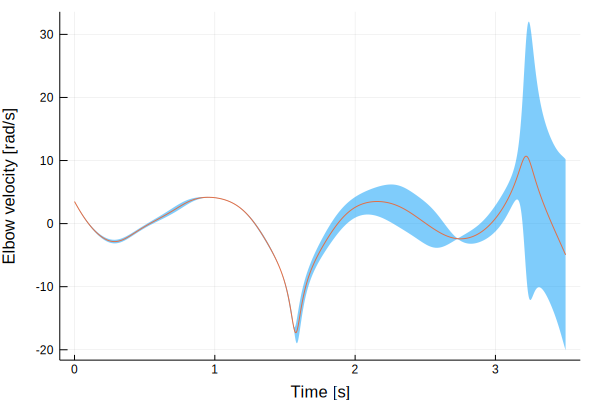

In [19]:
plot_elbow_velocity(sol)

Note the blowup in uncertainty due to the chaotic behavior of the double pendulum from this initial state.

## Adding damping

Now let's add some joint damping:

In [20]:
function damping!(τ::AbstractVector, t::Number, state::MechanismState)
    τ .= -5.0 .* velocity(state)
end
damped_dynamics = Dynamics(mechanism, damping!);

We'll use the same initial state as before:

In [21]:
set_velocity!(state, shoulder, 2.0)
set_velocity!(state, elbow, 3.5)
set_configuration!(state, shoulder, 0.4 ± 0.05)
set_configuration!(state, elbow, 0.5 ± 0.05);

In [22]:
problem = ODEProblem(damped_dynamics, state, tspan)
sol = solve(problem, RK4(), dtmin = dt, dtmax = dt, force_dtmin=true);

and plot the results again:

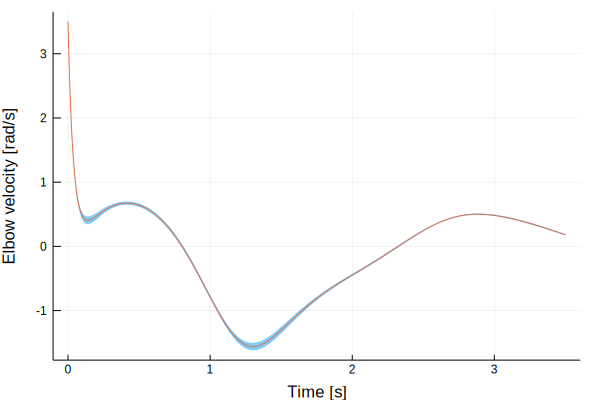

In [23]:
plot_elbow_velocity(sol)

As expected, adding a significant amount of damping greatly reduces the uncertainty in joint velocity over time.

# Take-home message

Because both RigidBodyDynamics.jl and DifferentialEquations.jl are coded generically enough to accept any input 'scalar types', it was easy to compose RigidBodySim.jl with Measurements.jl, resulting in a different view of the dynamical behavior without having to rewrite the core algorithms.